# Analyse de survie en pratique

## Quelques données

On récupère les données disponibles sur *open.data.gouv.fr* [Données hospitalières relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/). Ces données ne permettent pas de construire la courbe de [Kaplan-Meier](https://fr.wikipedia.org/wiki/Estimateur_de_Kaplan-Meier). On sait combien de personnes rentrent et sortent chaque jour mais on ne sait pas quand une personne qui sort un 1er avril est entrée.

In [17]:
import numpy.random as rnd

import pandas

df = pandas.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7",
    sep=";",
)
gr = df[["jour", "rad", "dc"]].groupby(["jour"]).sum()
diff = gr.diff().reset_index(drop=False)
diff.head()

,jour,rad,dc
0,2020-03-18,NaN,NaN
1,2020-03-19,695.0,207.0
2,2020-03-20,806.0,248.0
3,2020-03-21,452.0,151.0
4,2020-03-22,608.0,210.0


In [18]:
def donnees_artificielles(hosp, mu=14, nu=21):
    dt = pandas.to_datetime(hosp["jour"])
    res = []
    for i in range(hosp.shape[0]):
        date = dt[i].dayofyear
        h1 = hosp.iloc[i, 1]
        h2 = hosp.iloc[i, 2]
        if h1 < 0 or h2 < 0:
            continue
        delay1 = rnd.exponential(mu, int(h1))
        for j in range(delay1.shape[0]):
            res.append([date - int(delay1[j]), date, 1])
        delay2 = rnd.exponential(mu, int(h2))
        for j in range(delay2.shape[0]):
            res.append([date - int(delay2[j]), date, 0])
    return pandas.DataFrame(res, columns=["entree", "sortie", "issue"])


data = donnees_artificielles(diff[1:].reset_index(drop=True)).sort_values("entree")
data.head()

,entree,sortie,issue
1905678,-148,3,1
577877,-147,40,1
1126578,-140,6,1
1140232,-140,11,1
1205621,-131,26,1


Chaque ligne est une personne, `entree` est le jour d'entrée à l'hôpital, `sortie` celui de la sortie, `issue`, 0 pour décès, 1 pour en vie.

In [19]:
data.describe()

,entree,sortie,issue
count,1.993886e+06,1.993886e+06,1.993886e+06
mean,1.481621e+02,1.616597e+02,8.642781e-01
std,1.152239e+02,1.143726e+02,3.424931e-01
min,-1.480000e+02,1.000000e+00,0.000000e+00
25%,5.100000e+01,6.400000e+01,1.000000e+00
50%,1.130000e+02,1.250000e+02,1.000000e+00
75%,2.600000e+02,2.750000e+02,1.000000e+00
max,3.660000e+02,3.660000e+02,1.000000e+00


Il y a environ 80% de survie dans ces données.

In [20]:
import numpy

duree = data.sortie - data.entree
deces = (data.issue == 0).astype(numpy.int32)

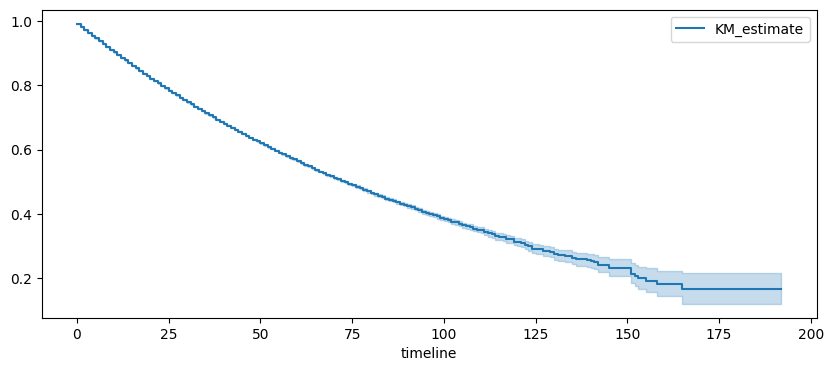

In [21]:
import numpy
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
kmf = KaplanMeierFitter()
kmf.fit(duree, deces)
kmf.plot(ax=ax)
ax.legend();

## Régression de Cox

On reprend les données artificiellement générées et on ajoute une variable identique à la durée plus un bruit mais quasi nul 

In [22]:
import pandas

data_simple = pandas.DataFrame(
    {
        "duree": duree,
        "deces": deces,
        "X1": duree * 0.57 * deces + numpy.random.randn(duree.shape[0]),
        "X2": duree * (-0.57) * deces + numpy.random.randn(duree.shape[0]),
    }
)
data_simple.head()

,duree,deces,X1,X2
1905678,151,0,0.650961,-1.128843
577877,187,0,-1.956525,0.108041
1126578,146,0,0.026987,-0.130392
1140232,151,0,1.149385,0.280224
1205621,157,0,-0.032398,0.400499


In [23]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_simple, test_size=0.8)

In [24]:
from lifelines.fitters.coxph_fitter import CoxPHFitter

cox = CoxPHFitter()
cox.fit(
    data_train[["duree", "deces", "X1"]],
    duration_col="duree",
    event_col="deces",
    show_progress=True,
)

Iteration 1: norm_delta = 5.01e-01, step_size = 0.9500, log_lik = -647954.57157, newton_decrement = 1.86e+04, seconds_since_start = 2.0
Iteration 2: norm_delta = 1.29e-01, step_size = 0.9500, log_lik = -668348.17665, newton_decrement = 2.19e+04, seconds_since_start = 4.2
Iteration 3: norm_delta = 8.30e-02, step_size = 0.9500, log_lik = -642917.75741, newton_decrement = 4.33e+03, seconds_since_start = 6.2
Iteration 4: norm_delta = 3.36e-02, step_size = 1.0000, log_lik = -637879.13496, newton_decrement = 4.09e+02, seconds_since_start = 8.5
Iteration 5: norm_delta = 3.94e-03, step_size = 1.0000, log_lik = -637443.76633, newton_decrement = 4.61e+00, seconds_since_start = 10.7
Iteration 6: norm_delta = 4.65e-05, step_size = 1.0000, log_lik = -637439.12353, newton_decrement = 6.25e-04, seconds_since_start = 13.0
Iteration 7: norm_delta = 6.33e-09, step_size = 1.0000, log_lik = -637439.12291, newton_decrement = 1.16e-11, seconds_since_start = 15.1
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 398777 total observations, 344439 right-censored observations>

In [25]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 398777 total observations, 344439 right-censored observations>
             duration col = 'duree'
                event col = 'deces'
      baseline estimation = breslow
   number of observations = 398777
number of events observed = 54338
   partial log-likelihood = -637439.12
         time fit was run = 2024-10-07 10:42:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1         0.06      1.06      0.00            0.06            0.06                1.06                1.06

           cmp to      z      p  -log2(p)
covariate                                
X1           0.00 176.66 <0.005       inf
---
Concordance = 0.75
Partial AIC = 1274880.25
log-likelihood ratio test = 21030.90 on 1 df
-log2(p) of ll-ratio test = inf

In [26]:
cox2 = CoxPHFitter()
cox2.fit(
    data_train[["duree", "deces", "X2"]],
    duration_col="duree",
    event_col="deces",
    show_progress=True,
)
cox2.print_summary()

Iteration 1: norm_delta = 5.01e-01, step_size = 0.9500, log_lik = -647954.57157, newton_decrement = 1.86e+04, seconds_since_start = 2.4
Iteration 2: norm_delta = 1.31e-01, step_size = 0.9500, log_lik = -668036.09368, newton_decrement = 2.18e+04, seconds_since_start = 5.0
Iteration 3: norm_delta = 8.29e-02, step_size = 0.9500, log_lik = -642745.26291, newton_decrement = 4.23e+03, seconds_since_start = 7.2
Iteration 4: norm_delta = 3.27e-02, step_size = 1.0000, log_lik = -637838.96866, newton_decrement = 3.84e+02, seconds_since_start = 9.4
Iteration 5: norm_delta = 3.70e-03, step_size = 1.0000, log_lik = -637430.64477, newton_decrement = 4.03e+00, seconds_since_start = 11.5
Iteration 6: norm_delta = 4.05e-05, step_size = 1.0000, log_lik = -637426.59011, newton_decrement = 4.72e-04, seconds_since_start = 13.6
Iteration 7: norm_delta = 4.77e-09, step_size = 1.0000, log_lik = -637426.58963, newton_decrement = 6.55e-12, seconds_since_start = 15.7
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 398777 total observations, 344439 right-censored observations>
             duration col = 'duree'
                event col = 'deces'
      baseline estimation = breslow
   number of observations = 398777
number of events observed = 54338
   partial log-likelihood = -637426.59
         time fit was run = 2024-10-07 10:42:35 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X2        -0.06      0.94      0.00           -0.06           -0.06                0.94                0.95

           cmp to       z      p  -log2(p)
covariate                                 
X2           0.00 -176.68 <0.005       inf
---
Concordance = 0.75
Partial AIC = 1274855.18
log-likelihood ratio test = 21055.96 on 1 df
-log2(p) of ll-ratio test = inf

In [27]:
cox.predict_cumulative_hazard(data_test[:5])

,1369970,834048,1217055,1119706,1444869
0.0,0.008909,0.008111,0.020118,0.008601,0.008080
1.0,0.017592,0.016017,0.039727,0.016985,0.015956
2.0,0.026273,0.023921,0.059330,0.025366,0.023830
3.0,0.035119,0.031975,0.079308,0.033908,0.031854
4.0,0.043795,0.039875,0.098901,0.042284,0.039724
...,...,...,...,...,...
156.0,0.532402,0.484742,1.202293,0.514034,0.482903
158.0,0.538375,0.490181,1.215783,0.519801,0.488322
163.0,0.538375,0.490181,1.215783,0.519801,0.488322
170.0,0.538375,0.490181,1.215783,0.519801,0.488322


In [28]:
cox.predict_survival_function(data_test[:5])

,1369970,834048,1217055,1119706,1444869
0.0,0.991131,0.991922,0.980083,0.991435,0.991952
1.0,0.982562,0.984111,0.961052,0.983159,0.984170
2.0,0.974069,0.976363,0.942396,0.974953,0.976452
3.0,0.965490,0.968530,0.923755,0.966661,0.968648
4.0,0.957150,0.960910,0.905833,0.958597,0.961055
...,...,...,...,...,...
156.0,0.587193,0.615856,0.300504,0.598078,0.616989
158.0,0.583696,0.612516,0.296478,0.594639,0.613656
163.0,0.583696,0.612516,0.296478,0.594639,0.613656
170.0,0.583696,0.612516,0.296478,0.594639,0.613656
